# Adding differentiable curve fits for tabular data

## Main message
If you're fitting a curve or surface to data and want to ever use gradient-based optimizers or Newton solvers, make sure to do it in a differentiable way.

## Intro and motivation

There are times that we want to fit a curve to data.
This data can be 1-dimensional or n-dimensional and may be regularly spaced, irregularly spaced, or sparse.
We will use the term "curve" in a general sense to mean everything from curves to surfaces to n-dimensional hypersurfaces here.
These curve fits go by many names, including regressions, surrogate models, metamodels, splines, and response surfaces.
This topic is inherently related to all three broad categories in the course, though we will mostly approach this from the model construction viewpoint.

Fitting a curve or surface to data naturally crops up in many different places, such as:
- Using tabulated engine performance data in an optimization
- Aerodynamic lift data from a wind tunnel or otherw analyses
- Geospatial resource mapping (gold in the ground, soil composition, weather patterns based on point radar measurements, etc)

When you do fit a curve to data, you must ensure 1) that the fit is reasonable compared to the training and verification data and 2) that the curve is differentiable and smooth if you use gradient-based optimizers or Newton solvers.

OpenMDAO has multiple built-in tools to help you fit curves to data -- you shouldn't have to code this up on your own!

## Simple approach
A straightforward approach is a piecewise linear approximation of the data set.
However, this produces C1 discontinuities at the data points, which means that the derivative changes instantly and thus is not well-defined.
This potentially causes a problem for gradient-based optimizers who rely on accurate and smooth gradient information.

Imagine when the optimal point is near one of those discontinuous points.
The optimizer would struggle to correctly iterate there and may be ill-behaved.
Our example case below shows this behavior and how to overcome it using OpenMDAO built-in methods. 

## How to add a smooth and differentiable curve fit
Instead of using a piecewise linear fit, we could use a piecewise cubic spline, or many other forms of nonlinear surrogate modeling techniques.
Take our example from before and fit a piecewise cubic spline to it.
Now the resulting interpolation is smooth, continuous, and well-suited for gradient-based optimizers.

There are many packages to help you do this, including Scipy, SMT, and OpenMDAO.
OpenMDAO has built-in components to help you do this, including `SplineComp` and `MetaModels`.
These all compute the derivatives automatically by using the built-in functionality provided by OpenMDAO.

All this being said, getting a reasonable and accurate fit for your data is important.
Always verify the correctness of your curve fits by performing leave-one-out and other testing.
[[Creating high-quality surrogate models]] has much more information about this.

## Example case showing linear and smooth fits
We now examine a simple case of fitting a curve to 1D data to illustrate what this looks like using built-in OpenMDAO methods.
First, we train an interpolation using `InterpND` for a piecewise linear fit, then use an `Akima spline` fit to obtain a smooth and continuous interpolation.
The two resulting interpolations are plotted below.

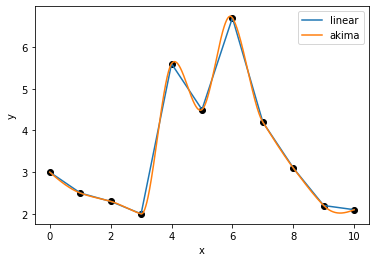

In [29]:
import numpy as np
from openmdao.components.interp_util.interp import InterpND
import matplotlib.pyplot as plt
import openmdao.api as om


x_training = np.arange(11)
y_training = np.array([3., 2.5, 2.3, 2., 5.6, 4.5, 6.7, 4.2, 3.1, 2.2, 2.1])

interp_linear = InterpND(method='slinear', points=x_training, values=y_training)
interp_akima = InterpND(method='akima', points=x_training, values=y_training)

plt.scatter(x_training, y_training, color='black')

x_range = np.linspace(0., 10., 1001)
plt.plot(x_range, interp_linear.interpolate(x_range), label='linear')

plt.plot(x_range, interp_akima.interpolate(x_range), label='akima')
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.show()

Next up, we perform a simple optimization on both of these interpolation functions to see how a gradient-based optimizer behaves.
In both, we're seeking the $x$ value from 0 to 10 that minimizes the interpolating function.
From a visual examination, we see that this occurs at $x=3$, but the optimizer does not have this knowledge.
It instead must traverse this 1D design space to find the optimal point.

Here, we use an OpenMDAO problem setup with the built-in `MetaModelStructuredComp` to obtain our interpolating functions.
We then use the gradient-based SLSQP optimizer to find the minima starting at $x=4$.

In [30]:
def run_interp_opt(method):
    # Create regular grid interpolator instance
    interp = om.MetaModelStructuredComp(method=method)

    # set up inputs and outputs
    interp.add_input('x', 4.0, training_data=x_training, units=None)
    interp.add_output('y', 1.0, training_data=y_training, units=None)

    prob = om.Problem()

    prob.model.add_subsystem('interps', interp, promotes=['*'])

    # setup the optimization
    prob.driver = om.ScipyOptimizeDriver()
    prob.driver.options['optimizer'] = 'SLSQP'
    prob.driver.options['tol'] = 1.e-9

    prob.driver.recording_options['includes'] = ['*']
    recorder = om.SqliteRecorder(f"{method}_cases.sql")
    prob.driver.add_recorder(recorder)

    prob.model.add_design_var('x', lower=0., upper=10.)
    prob.model.add_objective('y')

    prob.setup()

    # run the optimization
    prob.run_driver();

First, we run the optimization on the piecewise linear fit.

In [31]:
run_interp_opt('slinear')

Optimization terminated successfully    (Exit mode 0)
            Current function value: 2.000000000182022
            Iterations: 33
            Function evaluations: 211
            Gradient evaluations: 32
Optimization Complete
-----------------------------------


It takes 211 function evaluations, which is a lot!
The optimizer has a lot of trouble finding the minimum because there is a discontinuity in the derivatives there.
The optimizer wants to find the point in the function where it is the lowest value and where the derivative is 0, but the derivative instantly changes from a negative to a positive value at $x=3$, leading to very bad optimizer behavior.

However, if we optimize on the smooth Akima spline function, we see much better results.

In [32]:
run_interp_opt('akima')

Optimization terminated successfully    (Exit mode 0)
            Current function value: 1.9988172405361881
            Iterations: 6
            Function evaluations: 9
            Gradient evaluations: 6
Optimization Complete
-----------------------------------


It now only took 9 function evaluations and 6 gradient evaluations to find the optimum.
This is because the smooth function creates a much better posed optimization problem.

Of course this case is 1D and rather simple, but it quickly shows how discontinuities in the derivative space can severely hamper optimization performance.
If this interpolation is one part of a huge series of computations within your model, it would not be easy to spot this problem.

Thus, whenever you are fitting a curve or surface to data points, you should always use a smooth and differentiable fit to avoid any sort of poorly posed optimization problems.